# Pathway enrichment analysis and activity level scoring in human PBMC single cells
https://www.sc-best-practices.org/conditions/gsea_pathway.html

https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index

https://en.wikipedia.org/wiki/Dunn_index

https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.

https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_04_clustering.html

https://decoupler-py.readthedocs.io/en/latest/notebooks/progeny.html

## Motivation

Single-cell RNA-seq provides unprecedented insights into variations in cell types between conditions, tissue types, species and individuals. Differential gene expression analysis of the single-cell data is almost always followed by *gene set enrichment analysis*, where the aim is to identify gene programs, such as biological processes, gene ontologies or regulatory pathways that are over-represented in an experimental condition compared to control or other conditions, on the basis of differentially expressed (DE) genes. 

To determine the pathways enriched in a cell type-specific manner between two conditions, first a relevant collection of gene set signatures is selected, where each gene set defines a biological process (e.g. epithelial to mesenchymal transition, metabolism etc) or pathway (e.g. MAPK signalling). For each gene set in the collection, DE genes present in the gene set are used to obtain a test statistic that is then used to assess the enrichment of the gene set. Depending on the type of the enrichment test chosen, gene expression measurements may or may not be used for the computation of the test statistic. 

In this chapter, we first provide an overview of different types of gene set enrichment tests, introduce some commonly used gene signature collections and discuss best practices for pathway enrichment and functional enrichment analysis in general.  We conclude the chapter by demonstrating three analytical approaches for gene set enrichment analysis. Note that we use the terms pathway analysis, pathway enrichment analysis, gene set enrichment analysis and functional analysis interchangeably in this chapter. 

## Pathway and gene set collections

Gene sets are a curated list of gene names (or gene ids) that are known to be involved in a biological process through previous studies and/or experiments. The Molecular Signatures Database (MSigDB) {cite}`subramanian2005gene,liberzon2011molecular` is the most comprehensive database consisting of 9 collections of gene sets. Some commonly used collections are C5, which is the gene ontology (GO) collection, C2 collection of curated gene signatures from published studies that are typically context (e.g. tissue, condition) specific, but also include KEGG and REACTOME gene signatures. For cancer studies, the Hallmark collection is commonly used, and for immunologic studies the C7 collection is a common choice. Note that these signatures are mainly derived from Bulk-seq measurements and measure continuous phenotypes. Recently and with the wide-spread availability of scRNA-seq datasets, databases have evolved that provide curated marker lists derived from published single cell studies that define cell types in various tissues and species. These include CellMarker {cite}`zhang2019cellmarker` and PanglaoDB {cite}`franzen2019panglaodb`. Curated marker lists are not limited to those made available in databases, and can be curated by oneself.

### Gene set test vs. pathway activity inference 

Gene set tests test whether a pathway is enriched, in other words over-represented, in one condition compared to others, say, in healthy donors compared to severe COVID-19 patients. An alternative approach is to simply score the activity of a pathway or gene signature, in absolute sense, in individual cells, rather than testing for a differential activity between conditions. Some of the widely used tools for inference of gene set activity in general (including pathway activity) in individual cells include *VISION* {cite}`detomaso2019functional`, *AUCell* <cite>`aibar2017scenic`</cite>, pathway overdispersion analysis using *Pagoda2* <cite>`fan2016characterizing, lake2018integrative`</cite> and simple combined z-score <cite>`lee2008inferring`</cite>. 

*DoRothEA* <cite>`garcia2019benchmark`</cite> and *PROGENy* <cite>`schubert2018perturbation`</cite> are among functional analysis tools developed to infer transcription factor (TF) - target activities originally in Bulk RNA data. Holland et al. <cite>`holland2020robustness`</cite> found that Bulk RNA-seq methods *DoRothEA* and *PROGENy* have optimal performance in simulated scRNA-seq data, and even partially outperform tools specifically designed for scRNA-seq analysis despite the drop-out events and low library sizes in single cell data. Holland et al. also concluded that pathway and TF activity inference is more sensitive to the choice of gene sets rather than the statistical methods. This observation though can be specific to functional enrichment analyses and be explained by the fact that TF-target relations are context-specific; that is TF-target associations in one cell type may actually differ from another cell type or tissue.  

In contrast to Holand et al., Zhang et al. <cite>`zhang2020benchmarking`</cite> found that single-cell-based tools, specifically Pagoda2, outperform bulk-base methods from three different aspects of accuracy, stability and scalability. It should be noted that pathway and gene set activity inference tools inherently do not account for batch effects or biological variations other than the biological variation of interest. Therefore, it is up to the data analyst to ensure that the differential gene expression analysis step has worked properly.

Furthermore, while the tools mentioned here score every gene set in individual cells, they are not able to select for the most biologically relevant gene sets among all scored gene sets. scDECAF (https://github.com/DavisLaboratory/scDECAF) is a gene set activity inference tool that allows data-driven selection of the most informative gene sets, thereby aids in dissecting meaningful cellular heterogeneity.

### Prepare and explore the data

We first download the 25K PBMC data and follow the standard `scanpy` workflow for normalisation of read counts and subsetting on the highly variable genes. The dataset contains untreated and IFN-$\beta$ stimulated human PBMC cells <cite>`gspa:kang2018`</cite>. We explore patterns of variation in the data with UMAP representation of 4000 highly variable genes. 

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd

import scanpy as sc
import anndata as ad
import decoupler
import seaborn.objects as so
from tqdm.notebook import tqdm
import session_info
import os
import warnings
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform


os.environ["LOKY_MAX_CPU_COUNT"] = '4'
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

#Filtering warnings from current version of matplotlib.
warnings.filterwarnings("ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Tight layout not applied.*", category=UserWarning)

In [2]:
adata = sc.read("kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122")
print(adata)

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'


adata.X is a sparse matrix with 24673 cells x 15706 genes. It contains the float count of the gene expression values from the single cell experiment.

In [3]:
adata.X

<24673x15706 sparse matrix of type '<class 'numpy.float32'>'
	with 14184532 stored elements in Compressed Sparse Column format>

In [4]:
#Storing the counts for later use.
adata.layers["counts"] = adata.X.copy()
#Renaming label to condition.
adata.obs = adata.obs.rename({"label": "condition"}, axis=1)

#Normalizing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

While the current adata object comes with UMAP and PCA embeddings, these have been corrected for stimulation condition, which we don't want for this analysis. Instead we will recompute these.

In [5]:
%%time
#!pip install ipywidgets --upgrade
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

CPU times: total: 55.7 s
Wall time: 1min 4s


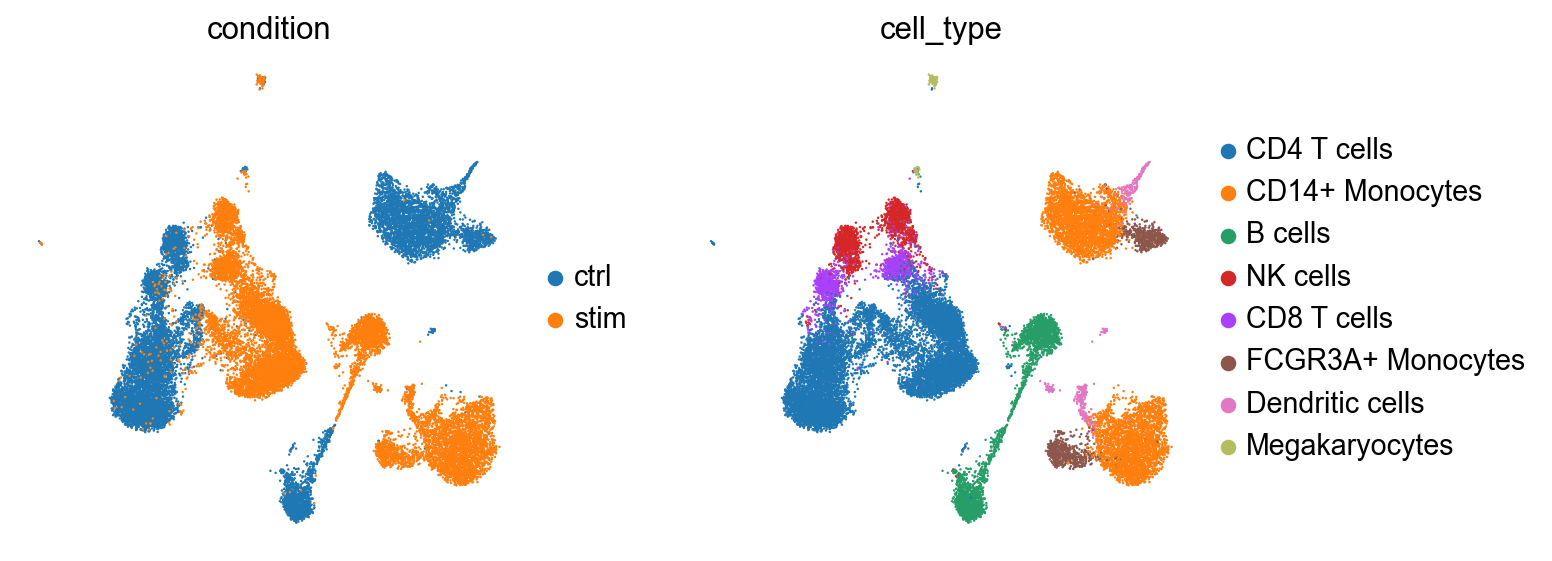

In [6]:
sc.pl.umap(adata, color=["condition", "cell_type"], frameon=False, ncols=2)

## GSEA

#### Retrieving gene sets
Download and read the `gmt` file for the REACTOME pathways annotated in the C2 collection of MSigDB. 

In [7]:
#Downloading reactome pathways.
from pathlib import Path

if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")
reactome.head()

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST


#### Running GSEA

Now we will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) <cite>`badia2022decoupler`</cite> to perform GSEA enrichment tests on our data. We use the normalized scores from sc.pp.normalize_total(adata) as a proxy for differential expression (DE) scores, which will significantly speed up the process since we don't have to calculate DE scores for each cell individually.

In [8]:
#Prepare the result matrix for GSEA scores.
num_cells = adata.shape[0]
num_gene_sets = len(reactome['geneset'].unique())
gsea_results_matrix = np.zeros((num_cells, num_gene_sets))

#Loop through each cell to run GSEA.
for cell_index in tqdm(range(num_cells)):
    #Get normalized expression values for the specific cell.
    cell_expr = adata.X[cell_index].toarray().flatten()
    
    #Create a DataFrame to hold DE scores.
    de_scores = pd.DataFrame(cell_expr, index=adata.var_names, columns=['scores'])
    
    #Run GSEA using decoupler.
    _, norm, _ = decoupler.run_gsea(
        de_scores.T,
        reactome,
        source="geneset",
        target="genesymbol"
    )
    
    #Store the normalized enrichment scores (NES) in the result matrix.
    gsea_results_matrix[cell_index, :] = norm.iloc[:, 0].values

#Save the result matrix for later use.
np.save('gsea_results_matrix.npy', gsea_results_matrix)

  0%|          | 0/24673 [00:00<?, ?it/s]

### Cluster With KMeans

c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


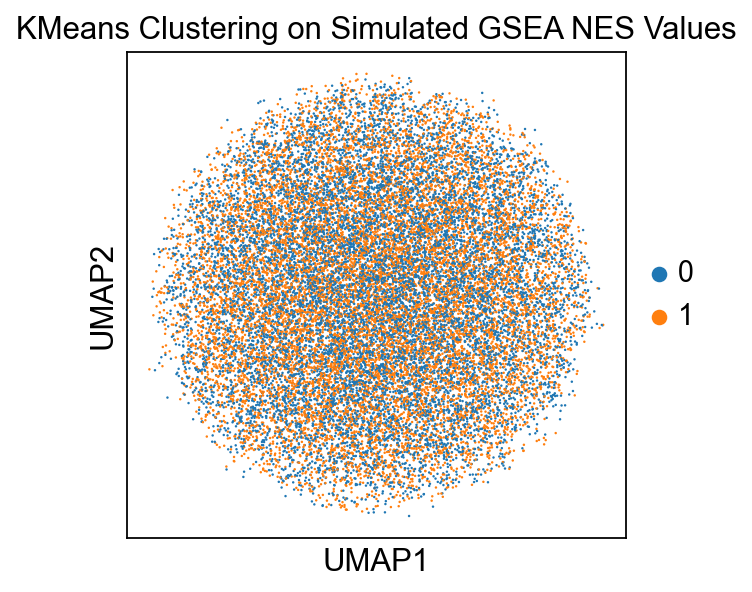

In [14]:
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt

#Load the simulated GSEA results matrix.
gsea_results_matrix = np.load('simulated_gsea_results_matrix.npy')

#Convert the result matrix to an AnnData object for visualization.
adata_gsea = sc.AnnData(X=gsea_results_matrix)
adata_gsea.var_names = [f'GeneSet_{i}' for i in range(gsea_results_matrix.shape[1])]
adata_gsea.obs_names = [f'Cell_{i}' for i in range(gsea_results_matrix.shape[0])]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=2, random_state=0).fit(gsea_results_matrix)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15, random_state=0)
umap_coords = umap_model.fit_transform(gsea_results_matrix)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata_gsea.obsm['X_umap'] = umap_coords
adata_gsea.obs['kmeans2'] = pd.Categorical(kmeans.labels_)

#Plot the UMAP with KMeans clustering results using Scanpy.
sc.pl.umap(adata_gsea, color=['kmeans2'], title='KMeans Clustering on Simulated GSEA NES Values')

### Cluster Results

 - Silhouette Score: This score measures how similar a point is to its own cluster compared to other clusters. The silhouette_score function from sklearn.metrics is used.
 - Calinski-Harabasz Index: This index evaluates the ratio of the sum of between-cluster dispersion and of within-cluster dispersion. The calinski_harabasz_score function from sklearn.metrics is used.
 - Dunn Index: This index is calculated by finding the minimum inter-cluster distance and dividing it by the maximum intra-cluster distance. The custom function dunn_index is used to compute this.

In [20]:
#Dunn index calculation function.
def dunn_index(X, labels):
    #Compute pairwise distances.
    distances = squareform(pdist(X))
    
    #Find unique cluster labels.
    unique_labels = np.unique(labels)
    
    #Calculate inter-cluster distances (minimum distance between points in different clusters).
    inter_cluster_dists = np.inf
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]
            inter_cluster_dists = min(inter_cluster_dists, np.min(distances[np.ix_(labels == unique_labels[i], labels == unique_labels[j])]))
    
    #Calculate intra-cluster distances (maximum distance within a cluster).
    intra_cluster_dists = 0
    for label in unique_labels:
        cluster = X[labels == label]
        intra_cluster_dists = max(intra_cluster_dists, np.max(pdist(cluster)) if len(cluster) > 1 else 0)
    
    #Calculate Dunn index.
    return inter_cluster_dists / intra_cluster_dists if intra_cluster_dists != 0 else np.inf

In [10]:
%%time
#Silhouette score.
silhouette_avg = silhouette_score(adata.obsm['X_umap'], kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(adata.obsm['X_umap'], kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
dunn = dunn_index(adata.obsm['X_umap'], kmeans.labels_)
print(f"Dunn Index: {dunn}")

Silhouette Score: 6.122695776866749e-05
Calinski-Harabasz Index: 2.5647431165906647


Calculating inter-cluster distances:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating intra-cluster distances:   0%|          | 0/2 [00:00<?, ?it/s]

Dunn Index: 1.323886733857937e-05


## PROGENy
PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. Here is a brief description of each pathway:
- Androgen: involved in the growth and development of the male reproductive organs.
- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- Estrogen: promotes the growth and development of the female reproductive organs.
- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.
- MAPK: integrates external signals and promotes cell growth and proliferation.
- NFkB: regulates immune response, cytokine production and cell survival.
- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- PI3K: promotes growth and proliferation.
- TGFb: involved in development, homeostasis, and repair of most tissues.
- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- Trail: induces apoptosis.
- VEGF: mediates angiogenesis, vascular permeability, and cell migration.
- WNT: regulates organ morphogenesis during development and tissue repair.

In [7]:
progeny = decoupler.get_progeny(organism='human', top=500)
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


To infer pathway enrichment scores we will run the multivariate linear model (mlm) method. For each cell in our dataset (adata), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

In [8]:
decoupler.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running mlm on mat with 24673 samples and 15706 targets for 14 sources.


100%|██████████| 3/3 [00:22<00:00,  7.45s/it]


### Cluster With KMeans

Pathway activity matrix shape: (24673, 14)


c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


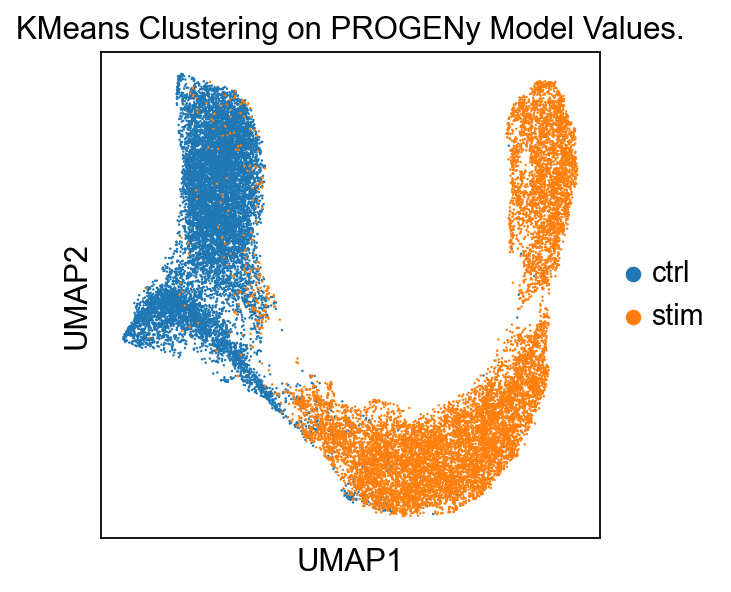

In [9]:
from sklearn.cluster import KMeans
import umap.umap_ as umap


acts = decoupler.get_acts(adata, obsm_key='mlm_estimate')

#Verify the structure of pathway activity matrix.
print("Pathway activity matrix shape:", acts.obsm['mlm_estimate'].shape)

#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = pd.DataFrame(
    acts.obsm['mlm_estimate'],
    index=adata.obs_names,
    columns=acts.var_names
)

#Add pathway activity to adata.obs.
#for pathway in acts.var_names:
    #adata.obs[pathway] = pathway_activity_df[pathway]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=2, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15, random_state=0)
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans3'] = pd.Categorical(adata.obs['condition'])

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on PROGENy Model Values.")

### Cluster Results

In [14]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = acts.obsm['mlm_estimate']

#Silhouette score.
silhouette_avg = silhouette_score(pathway_activity_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(pathway_activity_matrix, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
dunn = dunn_index(pathway_activity_matrix, kmeans.labels_)
print(f"Dunn Index: {dunn}")

Silhouette Score: 0.5684536695480347
Calinski-Harabasz Index: 51813.959684798625


Calculating intra-cluster distances:   0%|          | 0/2 [00:00<?, ?it/s]

Dunn Index: 0.03407455366083103
CPU times: total: 33.7 s
Wall time: 1min 52s


## AUCell

Unlike the previous approach where we assessed gene set *enrichment* per *cluster* (or rather cell type), one can *score* the activity level of pathways and gene sets in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. This we can achieve by activity scoring tools such as `AUCell`.

Similar to `GSEA`, we will be using the `decoupler` implementation of `AUCell`. Make sure to run the previous cell for downloading the REACTOME gene sets.

In [17]:
%%time
decoupler.run_aucell(
    adata,
    reactome,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)
adata

CPU times: total: 14min 27s
Wall time: 14min 7s


AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'kmeans3'
    var: 'name'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors', 'kmeans3_colors'
    obsm: 'X_pca', 'X_umap', 'mlm_estimate', 'mlm_pvals', 'aucell_estimate'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


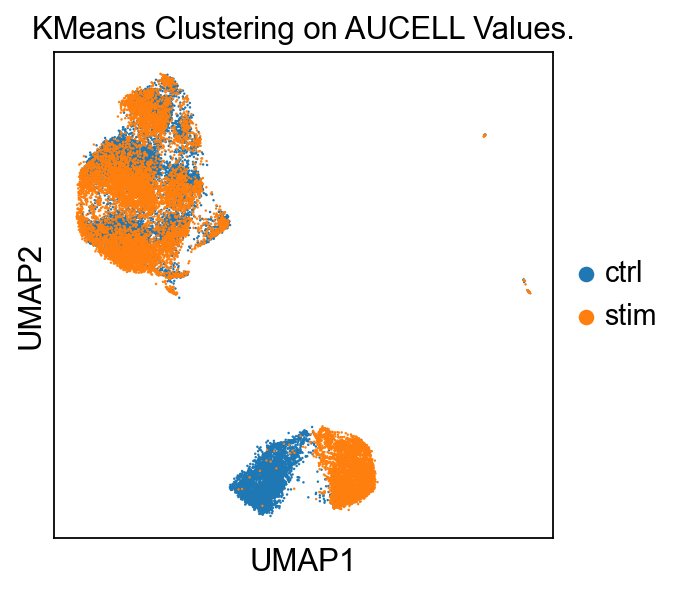

In [18]:
from sklearn.cluster import KMeans
import umap.umap_ as umap


#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = adata.obsm["aucell_estimate"]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=2, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15, random_state=0)
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans4'] = pd.Categorical(adata.obs['condition'])

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans4"], title="KMeans Clustering on AUCELL Values.")

### Cluster Results

In [19]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = adata.obsm['aucell_estimate']

#Silhouette score.
silhouette_avg = silhouette_score(pathway_activity_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(pathway_activity_matrix, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
dunn = dunn_index(pathway_activity_matrix, kmeans.labels_)
print(f"Dunn Index: {dunn}")

Silhouette Score: 0.13764698803424835
Calinski-Harabasz Index: 3215.894450359765


Calculating intra-cluster distances:   0%|          | 0/2 [00:07<?, ?it/s]

Dunn Index: 0.2627693665418968


## Session info

In [43]:
session_info.show()